## ML tests on Conical debris bed COCOMO simulations
#### ++++++
#### Author: Jasmin Joshi-Thompson
#### jasminjthompson@gmail.com
#### ++++++

## Workflow
1. Import sim results consiting of 
    - time  detected  SIM_ID      Psys  Ffuel  Porosity Dparticle  Alpha  Rflat    Tbed    Decay  Fstruct  
2. Normlaise and pred (1,0) quench or melt
3. Import quench front matrix
4. use NN to predict matrix from inputs

In [12]:
# Standard library imports
import os
import sys
import time
import io
from datetime import datetime
import math
import os
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import export_text
from IPython.display import Image
# Third-party library imports
import numpy as np
import ast
import pandas as pd

import json
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from adjustText import adjust_text
from fpdf import FPDF
from scipy import signal
from scipy.signal import argrelextrema, find_peaks, savgol_filter
import seaborn as sns
import joblib
import keras
import tensorflow as tf
import keras_tuner
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

#from tensorflow_addons.metrics import RSquare
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import RepeatedKFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, recall_score, f1_score, precision_score, roc_curve
#from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.utils import resample
import matplotlib.colors as colors
from matplotlib import gridspec
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score


# Tkinter imports
import tkinter as tk
from tkinter import filedialog, simpledialog
from tkinter.filedialog import askdirectory

# Placeholder for functions and other custom imports
# import h5py
# from keras.models import load_model
# import sns
# import simpledialog


      time  detected               SIM_ID      Psys  Ffuel  Porosity  \
0  5730.63    melted  batchlocal1_run0000  168500.0  0.865    0.3525   
1  1330.06  quenched  batchlocal1_run0001  402500.0  0.635    0.4275   

   Dparticle  Alpha  Rflat    Tbed    Decay  Fstruct  
0    0.00184   17.1   1.18  1219.0  0.00825   1.0025  
1    0.00456   24.9   0.78  1453.0  0.00405   1.4575  


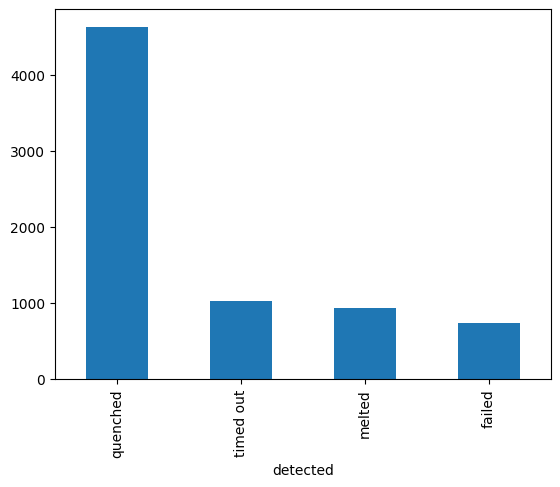

In [13]:
# open data
df = pd.read_csv(r"D:\Users\ikejjosh\Documents\COCOMO\debris_cone\sim_results.csv")
print(df.head(2))
#make histogram of detected columns for categorical data
df['detected'].value_counts().plot(kind='bar')
#replace 
og_df = df.copy()

In [14]:
# drop all rows that timed out or failed
df = df[df.detected != 'failed']

df = df[df.detected != 'timed out']

### Decision weather timed out scenario is a melting scenario
- Timed out is when the simulation hits 7200 seconds without quenching. This is a terminus for the simulation
- This could skew the prediction results as timing out is not a melting contidion, making the result non-continuious
- timed out could be added as a catagorical predictor - which is then passed on as a regression model for predicting the maximum quenching time

In [15]:
#convert catagorical data to numerical
df['detected'] = df['detected'].map({'quenched': 1, 'melted': 0})
df = df.drop(columns=['SIM_ID', 'time'])

# drop all rows with nan values
df = df.dropna()


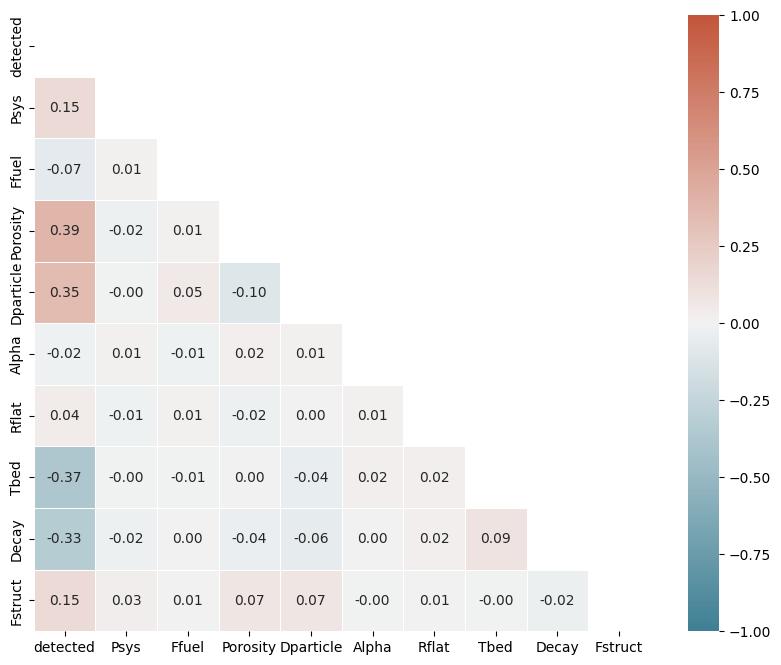

In [16]:
corr = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", ax=ax)

plt.show()


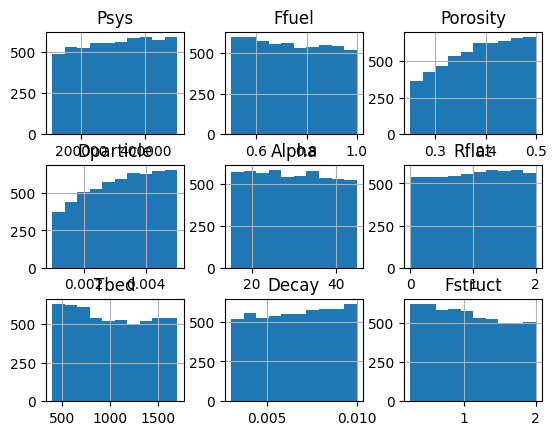

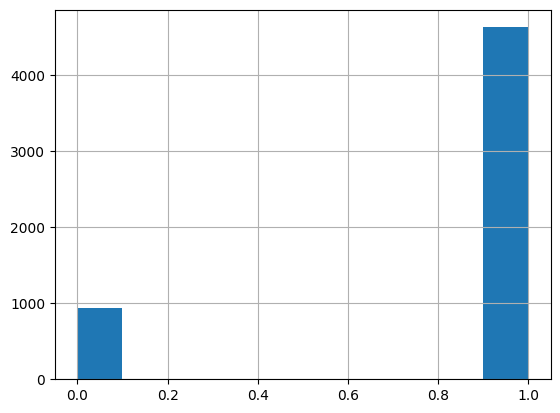

In [17]:
# Define features and labels
X = df.drop(columns='detected')
y = df['detected']
# plot distribution of each variable in X
X.hist()
plt.show()
# plot y distribution
y.hist()
plt.show()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# save data to csv
#X_train.to_csv('X_train.csv', index=False)
#X_test.to_csv('X_test.csv', index=False)
#y_train.to_csv('y_train.csv', index=False)
#y_test.to_csv('y_test.csv', index=False)

# Standardize the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
# save scalaer
joblib.dump(scaler, 'MinMax_scaler_X_Classification.pkl')
X_test = scaler.transform(X_test)

def evaluate_model(model, model_name):
    model.fit(X_train, y_train)

    # Save the model appropriately
    file_name = f"{model_name}.pkl" if model_name != 'XGBoost' else f"{model_name}.xgb"
    if os.path.exists(file_name):
        os.remove(file_name)  # Delete the existing file
    if model_name == 'XGBoost':
        model.save_model(file_name)  # XGBoost preferred format
    else:
        joblib.dump(model, file_name)  # Other models

    y_pred = model.predict(X_test)
    scores = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_pred)
    }
    return scores

# List to store performance results
results = []

''' Logistic Regression
log_reg = LogisticRegression()
results.append(evaluate_model(log_reg, 'Logistic Regression'))

# Random Forest
rf = RandomForestClassifier()
results.append(evaluate_model(rf, 'Random Forest'))

# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
results.append(evaluate_model(best_rf, 'Tuned Random Forest'))'''

# Support Vector Machine
svc = SVC(probability=True)
results.append(evaluate_model(svc, 'Support Vector Machine'))

# K-Nearest Neighbors
#knn = KNeighborsClassifier()
#results.append(evaluate_model(knn, 'K-Nearest Neighbors'))
#
# Gradient Boosting
#gb = GradientBoostingClassifier()
#results.append(evaluate_model(gb, 'Gradient Boosting'))

# AdaBoost
ada = AdaBoostClassifier()
results.append(evaluate_model(ada, 'AdaBoost'))

# Decision Tree
#dt = DecisionTreeClassifier()
#results.append(evaluate_model(dt, 'Decision Tree'))

# Gaussian Naive Bayes
#gnb = GaussianNB()
#results.append(evaluate_model(gnb, 'Gaussian Naive Bayes'))

# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
results.append(evaluate_model(lda, 'Linear Discriminant Analysis'))

## XGBoost
#xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
#results.append(evaluate_model(xgb, 'XGBoost'))

# LightGBM
lgbm = lgb.LGBMClassifier()
results.append(evaluate_model(lgbm, 'LightGBM'))

# Voting Classifier
voting_clf = VotingClassifier(estimators=[
      ('svc', svc), ('lda', lda), ('lgbm', lgbm), ('ada', ada)], voting='soft') #('xgb', xgb)('lr', log_reg), ('knn', knn),('gb', gb), ('rf', best_rf),    ('dt', dt), ('gnb', gnb), 

results.append(evaluate_model(voting_clf, 'Voting Classifier'))

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

d:\Users\ikejjosh\Documents\COCOMO\06_NNs\debris_cone\REGRESSION_APP\venv_app\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3691, number of negative: 765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 4456, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.828321 -> initscore=1.573777
[LightGBM] [Info] Start training from score 1.573777
[LightGBM] [Info] Number of positive: 3691, number of negative: 765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 4456, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.828321 -> initscore=1.573777
[LightGBM] [Info] Start training from score 1.573777


d:\Users\ikejjosh\Documents\COCOMO\06_NNs\debris_cone\REGRESSION_APP\venv_app\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


                          Model  Accuracy  Precision    Recall  F1 Score  \
0        Support Vector Machine  0.991921   0.995740  0.994681  0.995210   
1                      AdaBoost  0.987433   0.988397  0.996809  0.992585   
2  Linear Discriminant Analysis  0.982047   0.988323  0.990426  0.989373   
3                      LightGBM  0.986535   0.986330  0.997872  0.992068   
4             Voting Classifier  0.992819   0.994692  0.996809  0.995749   

    AUC-ROC  
0  0.985846  
1  0.966795  
2  0.963604  
3  0.961580  
4  0.984036  


In [19]:
# Sort by F1 Score and AUC-ROC
results_df.sort_values(by=['F1 Score', 'Recall'], ascending=False)


,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
4,Voting Classifier,0.992819,0.994692,0.996809,0.995749,0.984036
0,Support Vector Machine,0.991921,0.995740,0.994681,0.995210,0.985846
1,AdaBoost,0.987433,0.988397,0.996809,0.992585,0.966795
3,LightGBM,0.986535,0.986330,0.997872,0.992068,0.961580
2,Linear Discriminant Analysis,0.982047,0.988323,0.990426,0.989373,0.963604


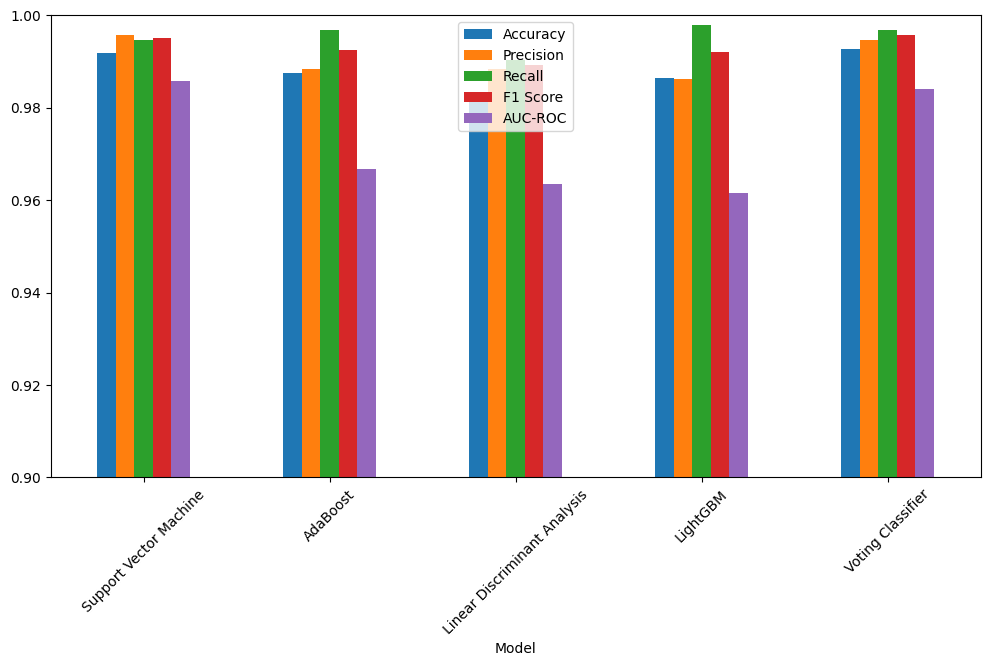

In [20]:
# make a bar chart of the results
results_df.plot(x='Model', y=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'], kind='bar', figsize=(12, 6))
plt.xticks(rotation=45)
# make y axus go from 0.9 to 1
plt.ylim(0.9, 1)
plt.show()

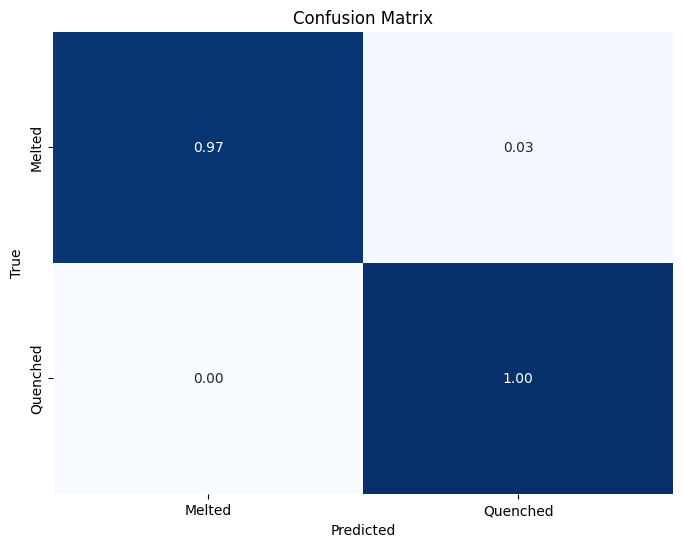

In [21]:
# confustion matrix of voting classifier
y_pred = voting_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Melted', 'Quenched'], yticklabels=['Melted', 'Quenched'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# how long does it take to make one prediction
start_time = time.time()
y_pred = voting_clf.predict(X_test)
end_time = time.time()
print("Time taken to make one prediction: ", end_time - start_time)

Time taken to make one prediction:  0.05020761489868164
